This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch lecture, seminar, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`, `plt.quiver plo). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [65]:
import matplotlib.pyplot as plt
from sklearn.mixture import GMM
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from scipy.stats import norm
import seaborn as sns
import time
import pylab as pl

from scipy.stats import multivariate_normal as norm
from sklearn import mixture
from matplotlib.colors import LogNorm

from IPython import display
%matplotlib inline

n_samples = M = 2000

def sample_distribution():
    shifted_gaussian = np.random.randn(n_samples, 2) + np.array([5, 30])
    C = np.array([[1., -0.7], [0.5, 1.7]])
    stretched_gaussian = np.dot(np.random.randn(n_samples, 2) + np.array([-5, 10]) , C)
    X_train = np.vstack([shifted_gaussian, stretched_gaussian])
    clf = GMM(n_components=2, covariance_type='full')
    clf.fit(X_train)
    return clf, X_train

def sample_noise(M):
    ls =np.linspace(-5,35, M)
    u = np.float32(np.vstack([ls, ls]).T + np.random.random((M, 2)) * 5)
    return u

def plot_d_boundary(discriminate):
    D = clf.sample(M)
    plt.plot(D, label='p_data')
    ds = discriminate(D)
    plt.plot(ds, label='decision boundary')
    plt.show()

In [60]:
def plot_before(generate, discriminate):    
    x = np.linspace(-110, 60)
    y = np.linspace(-60, 90)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    z = -clf.score_samples(XX)[0]
    z = z.reshape(X.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 16))
    noise = sample_noise(M)
    plt.scatter(noise[:, 0], noise[:, 1], 0.8)  
    
def plot_fig(generate, discriminate):    
    x = np.linspace(-110, 60)
    y = np.linspace(-60, 90)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    z = -clf.score_samples(XX)[0]
    z = z.reshape(X.shape)
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 16))
    noise = sample_noise(M)
    gs = generate(noise)
    plt.scatter(gs[:, 0], gs[:, 1], 0.8)      

In [2]:
G_input = T.matrix('Gx')
G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 10, nonlinearity=rectify)
G_l3 = lasagne.layers.DenseLayer(G_l2, 10, nonlinearity=rectify)
G_l4 = lasagne.layers.DenseLayer(G_l3, 2, nonlinearity=linear)
G = G_l4

G_out = lasagne.layers.get_output(G)

# discriminators
D1_input = T.matrix('D1x')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 10, nonlinearity=tanh)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 10, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 1, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 10, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 10, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 1, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

discriminate = theano.function([D1_input], D1_out, allow_input_downcast=True)
generate = theano.function([G_input], G_out, allow_input_downcast=True)

In [ ]:
# objectives
G_obj = (T.log(D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(1 - G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates, allow_input_downcast=True)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(1 - D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates, allow_input_downcast=True)

In [56]:
clf, X_train = sample_distribution()

### Training

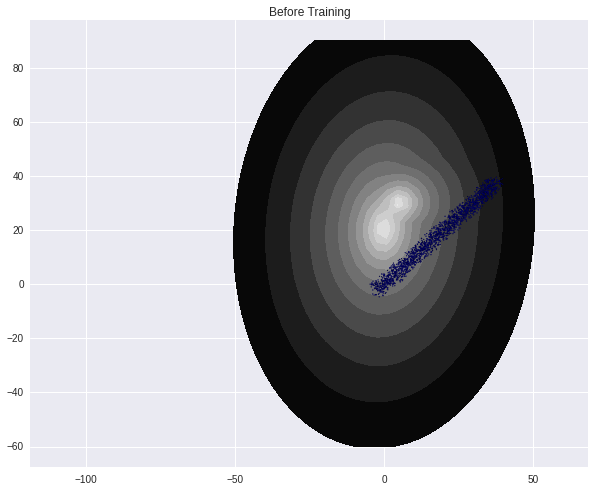

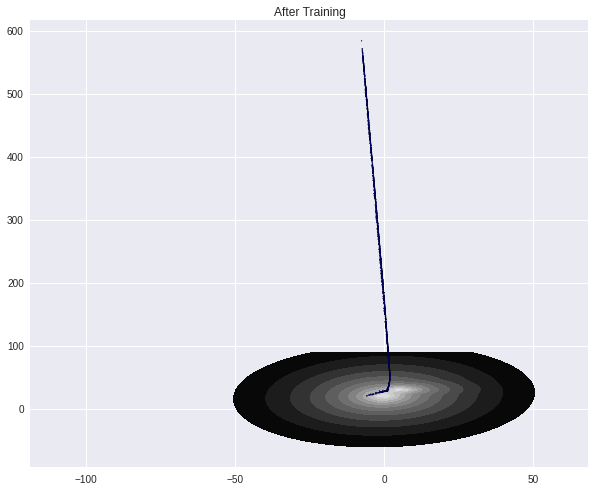

In [62]:
plot_before(generate, discriminate)
plt.title('Before Training')
plt.show()

epochs = 1000
k = 10


steps = []
steps.append(sample_noise(M))
visualize_training = False  # set to True to monitor training progress

for i in range(epochs):
    for j in range(k):
        x = clf.sample(M) #original 
        z = sample_noise(M)  #generated
        D_train(z.reshape(M, 2), x.reshape(M, 2))
    z = sample_noise(M) # generated
    G_train(z.reshape(M, 2))
    steps.append(generate(z))
    if i % 10 == 0: # lr decay
        G_lr *= 0.999
        D_lr *= 0.999
    if visualize_training:
        plt.clf()
        plot_fig(generate, discriminate)
        plt.draw()

plot_fig(generate, discriminate)
plt.title('After Training')
plt.show()

### Animation

In [ ]:
x = np.linspace(-30, 30)
y = np.linspace(-30, 30)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
z = -clf.score_samples(XX)[0]
z = z.reshape(X.shape)
    
for i in range(epochs+1):
    plt.figure(figsize=(10, 8))
    plt.contourf(X, Y, z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 16))
    noise = steps[i]
    plt.scatter(noise[:, 0], noise[:, 1], 0.8)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.002)
    plt.close()

In [ ]:
epochs = 1000
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20

visualize_training = True  # set to True to monitor training progress

#plt.ion()

for i in range(epochs):
    for j in range(k):
        x = clf.sample(M)  # sampled m-batch from p_data
        z = sample_noise(M)  # sample m-batch from noise prior
        histd[i] = D_train(z.reshape(M, 2), x.reshape(M, 2))
    z = sample_noise(M)
    histg[i] = G_train(z.reshape(M, 2))
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
    if visualize_training and not i%10:
        display.clear_output(wait=True)
        plt.clf()
        plt.figure(figsize=(8,8))
        plot_fig(generate, discriminate)
        plt.draw()
        plt.show()
        
#plt.ioff()